# Valley of shear

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri
from scipy.spatial import Delaunay
import ipyvolume as ipv
import ipywidgets as ipw

In [2]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

I keep the data separate from the code - the `schubtaltex.csv` file is kept in my home
directory 

`~/simdb/data/`

Adapt the path to the relevant location using `os.path.join`

In [3]:
import os.path as op
input_file = op.join(
    op.expanduser('~'), 'simdb', 'data', 'schubtaltex.csv'
)
input_file

'/home/rch/simdb/data/schubtaltex.csv'

Read the data using `loadtxt` to get a two dimensional array

In [4]:
xyz_data = np.loadtxt(input_file,delimiter=';',skiprows=1)

# Add corner points

Set up a rectangular domain around the measured data.
Currently, the values on the border are set to 1.0, which is not 
useful for cases when the border should stop at a certain cut through 
the boundaries. In such cases, the data values in $z$ direction 
along the boundary triangle edges should be projected onto the 
boundary of the bounding box. This has not yet been done here.

In [5]:
br = 0.01 # boundary ratio
min_rho, max_rho = (1-br) * np.min(xyz_data[:,0]), (1+0*br) * np.max(xyz_data[:,0])
min_lam, max_lam = (1-br) * np.min(xyz_data[:,1]), (1+br) * np.max(xyz_data[:,1])
mid_rho = (min_rho + max_rho) / 2
mid_lam = (min_lam + max_lam) / 2
cxyz = np.array([[min_rho, min_lam, 1],
                 [min_rho, max_lam, 1],
                 [max_rho, min_lam, 1],
                 [max_rho, max_lam, 1],
                [mid_rho*0.25, min_lam, 1],
                [mid_rho*0.5, min_lam, 1],
                [mid_rho*1.5, min_lam, 1],
                [mid_rho, max_lam, 1],
                [min_rho, mid_lam, 1],
#                 [max_rho, mid_lam, 0.3]
                ], dtype=np.float_)
rho_boundary = mid_rho * 0.02
lam_boundary = mid_lam * 0.02
mm_min_rho = -2 # min_rho-rho_boundary
mm_max_rho = max_rho+rho_boundary*(-0.0)
mm_min_lam = -1 
mm_max_lam = max_lam+5
bxyz = np.array([[mm_min_rho, mm_min_lam, 1],
                 [mid_rho, mm_min_lam, 1],
                 [mm_min_rho, mm_max_lam, 1],
                 [mm_max_rho, mm_min_lam, 1],
                 [mm_max_rho, mm_max_lam, 1],
                ], dtype=np.float_)
xyz = np.vstack([xyz_data, cxyz])#, bxyz])

# Construct the surface
First quick fix to connect the data is based on the $x-y$ plane
representing the slenderness 
\begin{align}
\lambda = \frac{a}{d}
\end{align}
and reinforcement ratio 
\begin{align}
\rho = \frac{A_\mathrm{st}}{b_w d}
\end{align}

Take the data along the first two axes, use the `trisurf` method of `Delaunay` to make an $xy$ triangulation

In [6]:
tri = Delaunay(xyz[:,:-1])
triangles=tri.simplices

# Plot using matplotlib with 3d projection
This version is static

In [7]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
x, y, z = xyz.T
ax.plot_trisurf(x, y, z, triangles=triangles, cmap=plt.cm.Spectral)
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\lambda$')
ax.set_zlabel(r'$M_\mathrm{uV} / M_\mathrm{Rd}$')
ax.view_init(20, 20)
ax.set_zlim(0,1);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Triangular interpolation

## Explanation using a symbolic implementation

Interpolate the values of the response surface using the 
triangular elements. Coordinates on the surface are defined as
\begin{align}
x_a = \xi_i \hat{x}_{ia}, \; i = 1\ldots3, \; a = 1\ldots2
\end{align}
where
\begin{align}
\xi_i \delta_{ii} = 1
\end{align}
Thus, a point within the triangle is defined by two values $\xi_1$, $\xi_2$ and the third one 
is obtained 
\begin{align}
\xi_3 = 1 - \xi_1 - \xi_2
\end{align}

For a point $x$, 
 - identify the triangle by evaluating 
 - identify the $\xi$ = $L_1$, $L_2$ and $L_3$ within the triangle
 - evaluate $u_\xi$

In [8]:
import sympy as sp
sp.init_printing()
xi_1, xi_2, xi_3 = sp.symbols(r'xi_1, xi_2, xi3')
xh_11, xh_21, xh_31 = sp.symbols(r'X_{11}, X_{21}, X_{31}')
xh_12, xh_22, xh_32 = sp.symbols(r'X_{12}, X_{22}, X_{32}')
x_a_1, x_a_2 = sp.symbols(r'x^\xi_1, x^\xi_2')
x_hat = sp.Matrix([[ xh_11, xh_21, xh_31],
                   [ xh_12, xh_22, xh_32]])
xi = sp.Matrix([xi_1, xi_2, xi_3])
x_a = sp.Matrix([x_a_1, x_a_2])

In [9]:
xi_3_subs = {xi_3: 1 - xi_1- xi_2} 
xi_3_subs

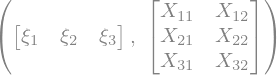

In [10]:
xi.T, x_hat.T

In [11]:
x_a_ = xi.T * x_hat.T
x_a_

In [12]:
x_a_.subs(xi_3_subs)

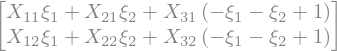

In [13]:
x_a2 = x_a_.subs(xi_3_subs).T
x_a2

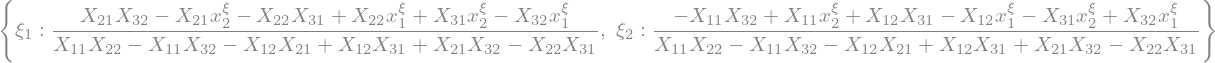

In [14]:
xi_12 = sp.solve(x_a - x_a2, [xi_1, xi_2])
xi_12

In [15]:
xi_12_ = sp.Matrix([xi_12[xi_1], xi_12[xi_2]])

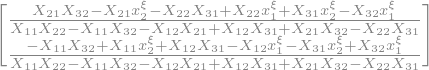

In [16]:
xi_12_

In [17]:
get_xi_12 = sp.lambdify((xh_11, xh_21, xh_31, xh_12, xh_22, xh_32, x_a_1, x_a_2), xi_12_, 'numpy')

In [18]:
def get_xi_123(*args):
    xi_12 = get_xi_12(*args)
    xi_3 = 1 - xi_12[0] - xi_12[1]
    return np.vstack([xi_12, xi_3]) #, axis=-1)

In [19]:
get_xi_123(0, 1, 0, 0, 0, 1, 0.5, 0.8)

array([[-0.3],
       [ 0.5],
       [ 0.8]])

## Numerical implementation

\begin{align}
\left[
\begin{array}{l}
    \xi_1 \\ \xi_2 \\ \xi_3
\end{array}
\right]
    &=
\left[
\begin{array}{l}
    0 \\ 0 \\ 1
\end{array}
\right] +
\left[
\begin{array}{rr}
1 & 0  \\
0 & 1  \\
-1 & -1 
\end{array}
\right]
\left[
\begin{array}{l}
    \xi_1 \\ \xi_2
\end{array}
\right]
\end{align}

In [20]:
delta_3_ib = np.array([[1,0],
                   [0,1],
                   [-1,-1]], dtype=np.float_)
I_i = np.array([0,0,1], dtype=np.float_).T

that can be expressed as
\begin{align}
\xi_i = I_i + \delta^{(3)}_{ib} \xi_b, \; i = 1\ldots3, \; b = 1\ldots2
\end{align}

Thus we can rewrite the approximation using $b =1 \ldots 2$
\begin{align}
x_a = \hat{x}_{ia} (I_i + \delta^{(3)}_{ib} \xi_b)  , \; i = 1\ldots3, \; a = 1\ldots2, \; b = 1\ldots2
\end{align}

which can be rearranged to
\begin{align}
\hat{x}_{ia} \delta^{(3)}_{ib} \xi_b = x_a - \hat{x}_{ia} I_i
\end{align} 

\begin{align}
\xi_b = \left[ \hat{x}_{ia} \delta^{(3)}_{ib} \right]^{-1}  
\left( x_a -  \hat{x}_{ia} I_i 
\right)
\end{align}

The calculation of the $\xi_i$ is done using the following procedure. The inputs are the triangulation nodes arranged in array with `Tia` dimensions and grid coordinates of the nodes `JKa`. 

In [21]:
def get_xi_TJi(hat_x_Tia, x_JKa):
    # remember the grid shape
    x_sh = x_JKa.shape[:-1]
    # flatten the grid nodes to have linear index at first position
    x_Ja = x_JKa.reshape(-1,2)
    # evaluate the inverse mapping matrix (see above)
    inv_x_delta_Tab = np.linalg.inv( np.einsum('Tia,ib->Tab', hat_x_Tia, delta_3_ib) )
    # distance matrix between triangle nodes and grid nodes
    x_I_TJa = x_Ja[None,:,:] - np.einsum('Tia,i->Ta', hat_x_Tia, I_i)[:,None,:]
    # get the xi_b - with two independent barycentric coordinates
    xi_TJb = np.einsum('Tba,TJa->TJb', inv_x_delta_Tab, x_I_TJa)
    # expand the barycentric coordinates to contatin 3 components
    xi_TJi = I_i[None,None,:] + np.einsum('ib,TJb->TJi', delta_3_ib, xi_TJb)
    # reshape the barycentric map back to the input shape of x_JKa and return
    xi_sh = (-1,) + x_sh + (3,)
    return xi_TJi.reshape(*xi_sh)

**Verification plots**

In [22]:
def plot_triangulation( ax, hat_x_Ia, T_i ):
    hat_x_Tia_closed = hat_x_Ia[np.hstack([T_i, T_i[...,[0]]])]
    ax.plot(*np.einsum('Tia->aiT',hat_x_Tia_closed), color='blue');

In [23]:
def plot_points(ax, x_Ja):
    ax.plot(*np.einsum('Ja->aJ',x_Ja)[:,None,:], color='red', marker='o')

## Example
Define nodes of the triangulation

Define the nodes of the triangulation hat_x_Ia where I is the index of triangulation, a is the dimensional index [0,1]. The array `I_Ti` is the map of triangles - for a given triangle index `T` and local node index `i` within a triangle return the global node of the triangulation  `I`

In [24]:
hat_x_Ia = np.array([[0,0],[1,0],[1,2],[0,1],[0,2]], dtype=np.float_)
I_Ti = np.array([[0,1,3],[1,2,3],[2,3,4]], dtype=np.int_)

In [25]:
z_I1 = np.zeros_like(hat_x_Ia[...,0], dtype=np.float_)
z_I1[3] = 1

Rearrange the node coordinates according the triangulation to make them accessible via the index triple `Tia`

In [26]:
hat_x_Tia = hat_x_Ia[I_Ti]

Define the grid `x_aJK`. Mgrid generates the array with the dimensional index on the first position. Rearrange the index order using `einsum`

In [27]:
x_aJK = np.mgrid[0:1:3j,0:2:3j]
x_JKa = np.einsum('aJK->JKa', x_aJK)

Flatten the first grid index `JK` of `x_JKa` to plot the points.

In [28]:
x_Ja = x_JKa.reshape(-1,2)
fig, ax = plt.subplots(1,1,figsize=(4,4))
plot_triangulation(ax, hat_x_Ia, I_Ti)
plot_points(ax, x_Ja)
ax.axis('equal');

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Identify the containing triangle `T` of a grid point `JK`

In [29]:
def get_xi_JTi(xi_TJi):
    # Put the grid node indexes at the first pos.
    return np.einsum('T...i->...Ti', xi_TJi)

Get the index of the triangle corresponding to the node `J`

In [30]:
def get_J_T(xi_TJi):
    # take only triangles with all xi >=0  
    mask_TJ = np.all(xi_TJi>=0, axis=-1)
    # find the first containing triangle
    J_T = np.argmax(mask_TJ, axis=-1) 
    return J_T

Get the barycentric coordinates of `x_Ja` within the respective containing triangle

In [31]:
def get_xi_Ji(xi_JTi, J_T):
    sh_JT = J_T.shape 
    n_T = xi_JTi.shape[-2]
    xi_JTi_ = xi_JTi.reshape(-1, n_T, 3)
    J_T_ = J_T.flatten()
    xi_Ji_ = xi_JTi_[np.arange(len(J_T_)), J_T_]
    return xi_Ji_.reshape(sh_JT + (3,)) 

Recover the original coordinates $x_a$

In [32]:
def get_z_JK(hat_x_Ia, I_Ti, x_aJK, z_I):
    x_JKa = np.einsum('aJK->JKa', x_aJK)
    hat_x_Tia = hat_x_Ia[I_Ti]
    z_Ti = z_I[I_Ti]
    xi_TJi = get_xi_TJi(hat_x_Tia, x_JKa)
    xi_JTi = get_xi_JTi(xi_TJi)
    J_T = get_J_T(xi_JTi)
    xi_Ji = get_xi_Ji(xi_JTi, J_T)
    z_Ji = z_Ti[J_T]
    z_JK = np.einsum('...i,...i->...', xi_Ji, z_Ji)
    return z_JK

In [33]:
z_JK = get_z_JK(hat_x_Ia, I_Ti, x_aJK, z_I1)

## Plot the triangulated data

Choose the resolution in the $\rho$ and $\lambda$ directions 

In [34]:
n_J, n_K = 99, 99
x_aJK = np.mgrid[min_rho:max_rho:complex(n_J),
                 min_lam:max_lam:complex(n_K)]
x_JK, y_JK = x_aJK

In [35]:
hat_x_Ia = xyz[:,:-1]
I_Ti = triangles
z_I = xyz[:,-1]
z_JK = get_z_JK(hat_x_Ia, I_Ti, x_aJK, z_I)

In [36]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(x_JK, y_JK, z_JK, cmap=plt.cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1.01)
ax.zaxis.set_major_locator(plt.LinearLocator(10))
ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5);


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [37]:
H_JK = np.ones_like(z_JK)
H_JK[x_JK < min_rho] = 0
H_JK[x_JK > max_rho] = 0
H_JK[y_JK < min_lam] = 0
H_JK[y_JK > max_lam] = 0

# Ironing
This is just a sketch - something more advanced is needed. Maybe some inspiration is here:


\begin{align}
\bar{f}(x) = \int   \frac{\alpha(x - \xi)}{\int \alpha(x - \xi)\;\mathrm{d}\xi} f(\xi) \; \mathrm{d}\xi
\end{align}

Gigen the coordinate grid $x_{JK}, y_{JK}$ calculate the distances between each two nodes (JK), (MN).
as 
\begin{align}
 r_{IJMN} = (x_{IJ}-x_{MN})^2 + ( y_{IJ} - y_{MN} )^2 
\end{align}

Scale the x-y plane to a unit square

Use the ironing function
\begin{align}
 \alpha = \exp{\left(-\frac{r^2}{2R^2}\right)}
\end{align}
in the integral above

Note that this procedure provides serves for non-local averaging of field function weighted by the distance from an actual point.

In [38]:
def get_z_MN_ironed(x_JK, y_JK, z_JK, RR):
    min_x, max_x = np.min(x_JK), np.max(x_JK)
    min_y, max_y = np.min(y_JK), np.max(y_JK)
    len_x = max_x - min_x
    len_y = max_y - min_y
    nx_JK = (x_JK - min_x) / len_x
    ny_JK = (y_JK - min_y) / len_y
    d_x = len_x / n_J
    d_y = len_y / n_K
    a_dxdy = d_x * d_y
    delta_x_JK = nx_JK[None,None,...] - nx_JK[...,None,None]
    delta_y_JK = ny_JK[None,None,...] - ny_JK[...,None,None]
    r2_n = (delta_x_JK**2 + delta_y_JK**2) / (2*RR**2) # (2*R**2)
    alpha_r_MNJK = np.exp(-r2_n)
    print(alpha_r_MNJK.shape, nx_JK.shape)
    a_MN = np.trapz(np.trapz(alpha_r_MNJK, nx_JK[:,0], axis=-1), ny_JK[0,:], axis=-1)
    normed_a_MNJK = np.einsum('MNJK,MN->MNJK', alpha_r_MNJK, 1 / a_MN)
    z_MNJK = np.einsum('...JK,JK->...JK',normed_a_MNJK, z_JK)
    z_MN = np.trapz(np.trapz(z_MNJK, nx_JK[:,0], axis=-1), ny_JK[0,:], axis=-1)
    return z_MN

In [39]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

def plot(ax, x_JK, y_JK, z_MN):
    surf = ax.plot_surface(x_JK, 
                           y_JK, 
                           z_MN,cmap=plt.cm.coolwarm,
                           linewidth=0)
    return surf

# Add a color bar which maps values to colors.
xs, ys, zs = xyz.T

azim=30
elev=45

def update_azim(elev, azim):
    ax.view_init(elev=elev, azim=azim)
    fig.show()

def update(R):
    print('R-refreshing for', R)
    ax.clear()
    ax.set_zlim(0, 1.0)
    ax.set_xlabel(r'$\rho$')
    ax.set_ylabel(r'$\lambda$')
    ax.set_zlabel(r'$M\mathrm{uV} / M\mathrm{Rd}$')
    ax.zaxis.set_major_locator(plt.LinearLocator(10))
    ax.zaxis.set_major_formatter(plt.FormatStrFormatter('%.02f'))
    z_MN = get_z_MN_ironed(x_JK, y_JK, z_JK, R)
    ax.scatter( xs, ys, zs=zs, zdir='z', marker='o', depthshade=True)
    print('plotting')
    surf = plot(ax, x_JK, y_JK, z_MN) 
    ax.view_init(elev=elev, azim=azim)
    
R_max = 0.3
# sliders
R_slider = ipw.FloatSlider(description=r'iron radius', value=0.06, min=0.001,max=0.3,step=R_max/40,
                                 continuous_update=False)
azim_slider = ipw.FloatSlider(description=r'azimuth', value=30, min=-90,max=90,step=1,              
                               continuous_update=True)
elev_slider = ipw.FloatSlider(description=r'elevation', value=30, min=-90,max=90,step=1,              
                               continuous_update=True)

# couple sliders with methods to call upon sliding
i1 = ipw.interactive_output(
    update, {'R': R_slider})
i2 = ipw.interactive_output(
    update_azim, {'azim': azim_slider,'elev': elev_slider});

# layout
hbox = ipw.HBox([R_slider, azim_slider, elev_slider])
display(hbox, i1, i2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Output()

Output()